## Definicion de Generador LXM

In [8]:
from numpy import uint64
import numpy as np
N_BITS = uint64(64)
def rotateLeft(n, d):
    n = uint64(n)
    d = uint64(d)
    return (n << d)|(n >> (N_BITS - d))

def shiftLeft(n, d):
    n = uint64(n)
    d = uint64(d)
    return n << d

def shiftRight(n, d):
    n = uint64(n)
    d = uint64(d)
    return n >> d

class LXM:

    M = uint64(0xd1342543de82ef95)
    a = uint64(13)
    s = uint64(0)
    x0 = uint64(11)
    x1 = uint64(57)
    c = uint64(0xdaba0b6eb09322e3)
    
    def nextRand(self, n=1):
        if n < 1:
            raise Exception("'n' must be 1 or greater")

        numbers = []
        for i in range(n):
            # Combining operation
            z = self.s + self.x0
            # Mixing function (lea64)
            z = (z ^ (shiftRight(z, 32))) * self.c
            z = (z ^ (shiftRight(z, 32))) * self.c
            z = (z ^ (shiftRight(z, 32)))
            # Update the LCG subgenerator
            self.s = self.M * self.s + self.a
            # Update the XBG subgenerator (xoroshiro128v1_0)
            q0, q1 = self.x0, self.x1
            q1 ^= q0
            q0 = rotateLeft(q0, 24)
            q1 = q0 ^ q1 ^ (shiftLeft(q1, 24))
            q1 = rotateLeft(q1, 37)
            self.x0, self.x1 = q0, q1
            #result
            numbers.append(z / uint64(-1))
            
        return numbers[0] if n==1 else np.array(numbers)

    def generate_normal(self, mean, deviation, n):
        if n < 1:
            raise Exception("'n' must be 1 or greater")
        U1 = self.nextRand(n)
        U2 = self.nextRand(n)
        R = np.sqrt(-2* np.log(U1))
        Theta = 2 * np.pi * U2
        #normal_1 = R * np.cos(Theta)
        normal = R * np.sin(Theta)
        return deviation*normal + mean
        

### Liberias necesarias

In [2]:
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
gen = LXM()

### Generar numeros con distribucion uniforme en el intervalo 0 - 1

<AxesSubplot:ylabel='Count'>

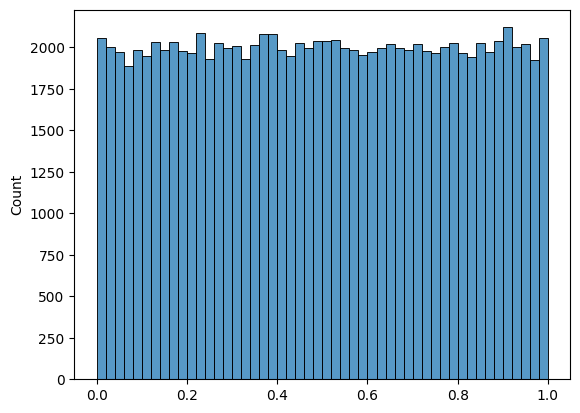

In [3]:
arr = gen.nextRand(100_000)

sns.histplot(bins=50, x=arr)

### Generacion de uniforme en el intervalo a - b

<AxesSubplot:ylabel='Count'>

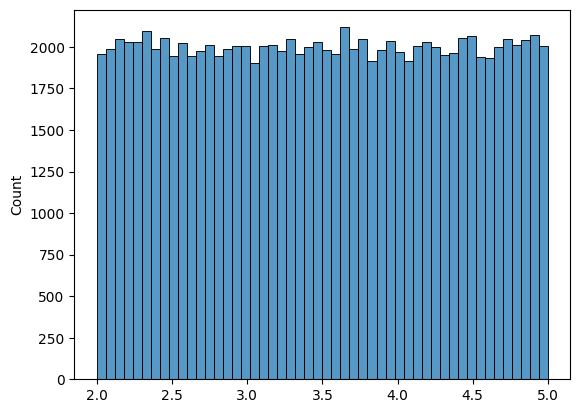

In [4]:
a = 2
b = 5
nums = gen.nextRand(100_000)
nums = nums * (b-a) + a

sns.histplot(bins=50, x=nums)


### Generacion de Normal Estandar con 2 uniformes - Metodo de Box Muller

<AxesSubplot:ylabel='Count'>

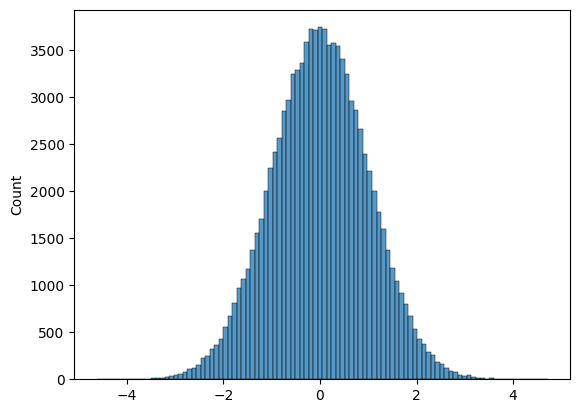

In [5]:
sns.histplot(bins=100, x=gen.generate_normal(0, 1, 100_000))

### Generar la variable aleatoria Normal con esperanza E y desvio D

<AxesSubplot:ylabel='Count'>

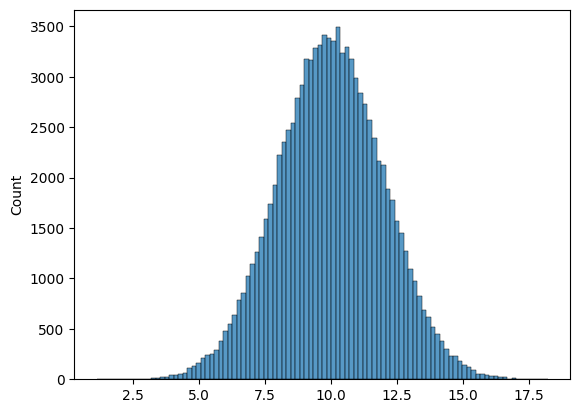

In [6]:

normal2 = gen.generate_normal(10, 2, 100_000)
sns.histplot(bins=100, x=normal2)

In [7]:
# Verificamos
esp = round(normal2.mean(), 2)
desv = round(normal2.std(), 2)
print(f'Normal\nEsperanza = {esp}\nDesvio = {desv}')

Normal
Esperanza = 10.0
Desvio = 2.0


## Test de Kolmogorov Smirnov
* H0: La muestra sigue una distribucion uniforme
* H1: La muestra no sigue una distribucio uniforme

Vemos si podemos rechazar (o no) H0.

In [9]:
from scipy import stats
for n in [10, 10_000, 100_000]:
    data = gen.nextRand(n)
    kstest_test = stats.kstest(data, 'uniform')
    if kstest_test.pvalue > 0.05:
        print('Datos uniformes (No se puede rechazar H0)')
    else:
        print('Datos no uniformes (Se rechaza H0)')

Datos uniformes (No se puede rechazar H0)
Datos uniformes (No se puede rechazar H0)
Datos uniformes (No se puede rechazar H0)


## Test de normalidad 

* H0: La muestra sigue una distribucion normal
* H1: La muestra no sigue una distribucio normal

Vemos si podemos rechazar (o no) H0.

In [10]:
# Anderson-Darling Test
from scipy.stats import anderson

for n in [10, 10_000]:
    print(f"\nTest n = {n}")
    data = gen.generate_normal(2, 10, n)
    #Ejecutamos el test de normalidad (por defecto compara contra Normal)
    resultado = anderson(data)
    print('Estadístico: %.3f' % resultado.statistic)
    for i in range(len(resultado.critical_values)):
        nivel_significancia, umbral = resultado.significance_level[i]/100, resultado.critical_values[i]
        if resultado.statistic < resultado.critical_values[i]:
            print('%.3f: %.3f, Datos normales (No se puede rechazar H0)' % (nivel_significancia, umbral))
        else:
            print('%.3f: %.3f, Datos No normales (Se rechaza H0)' % (nivel_significancia, umbral))


Test n = 10
Estadístico: 0.585
0.150: 0.501, Datos No normales (Se rechaza H0)
0.100: 0.570, Datos No normales (Se rechaza H0)
0.050: 0.684, Datos normales (No se puede rechazar H0)
0.025: 0.798, Datos normales (No se puede rechazar H0)
0.010: 0.950, Datos normales (No se puede rechazar H0)

Test n = 10000
Estadístico: 0.274
0.150: 0.576, Datos normales (No se puede rechazar H0)
0.100: 0.656, Datos normales (No se puede rechazar H0)
0.050: 0.787, Datos normales (No se puede rechazar H0)
0.025: 0.918, Datos normales (No se puede rechazar H0)
0.010: 1.092, Datos normales (No se puede rechazar H0)


### Test de Saphiro para distribucion normal

In [11]:
from scipy import stats
for n in [10, 10_000, 100_000]:
    data = gen.generate_normal(2, 10, n)
    shapiro_test = stats.shapiro(data)
    if shapiro_test.pvalue > 0.05:
        print('Datos normales (No se puede rechazar H0)')
    else:
        print('Datos no normales (Se rechaza H0)')

Datos normales (No se puede rechazar H0)
Datos normales (No se puede rechazar H0)
Datos normales (No se puede rechazar H0)
